In [4]:
import pandas as pd

# Load dataset
file_path = '/content/E-commerce_data.xlsx'

# Load the relevant tables
customers = pd.read_excel(file_path, sheet_name='customers')
genders = pd.read_excel(file_path, sheet_name='genders')
cities = pd.read_excel(file_path, sheet_name='cities')
transactions = pd.read_excel(file_path, sheet_name='transactions')

# Merge customer demographic data with transactions
customers = customers.merge(genders, on='gender_id').merge(cities, on='city_id')

# Preview the merged dataset
customers.head()


,customer_id,join_date,city_id,gender_id,gender_name,city_name
0,1,2022-01-08,7,1,Male,Mansoura
1,6,2023-01-31,7,1,Male,Mansoura
2,31,2023-01-09,7,1,Male,Mansoura
3,33,2024-02-08,7,1,Male,Mansoura
4,42,2021-09-25,7,1,Male,Mansoura


In [5]:
# Feature engineering: Create features like transaction frequency, number of burnt coupons, etc.
# Calculate the total number of transactions per customer
customer_transactions = transactions.groupby('customer_id').agg({
    'transaction_id': 'count',
    'transaction_status': lambda x: sum(x == 'burnt')
}).reset_index()

# Rename columns for clarity
customer_transactions.columns = ['customer_id', 'total_transactions', 'total_burnt']

# Merge transactional data with customer demographics
customer_segmentation_data = customers.merge(customer_transactions, on='customer_id')

# Select relevant features for clustering
features = customer_segmentation_data[['total_transactions', 'total_burnt', 'gender_id', 'city_id']]

# Standardize the features (important for clustering algorithms)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

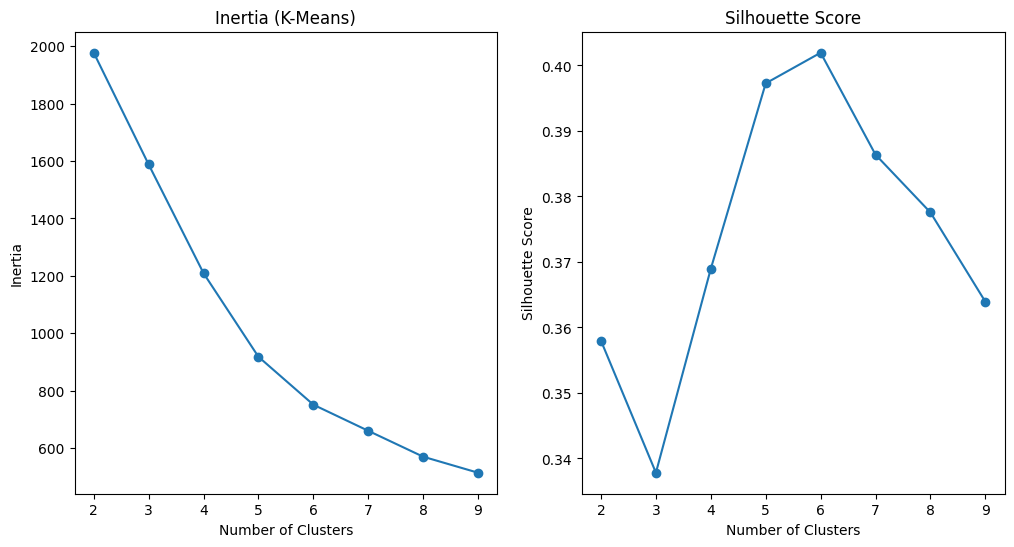

In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Try different values of K for K-Means
inertia = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Plot Inertia and Silhouette Scores to find the optimal number of clusters
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, marker='o')
plt.title('Inertia (K-Means)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.show()


In [7]:
# Choose the optimal K (let's assume K=3 for this example)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_segmentation_data['cluster'] = kmeans.fit_predict(scaled_features)

# View the first few customers with their assigned cluster
customer_segmentation_data[['customer_id', 'total_transactions', 'total_burnt', 'cluster']].head()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,customer_id,total_transactions,total_burnt,cluster
0,1,7,0,1
1,6,4,0,1
2,31,4,0,1
3,33,2,0,1
4,42,2,0,1


In [8]:
# Analyze each cluster
cluster_summary = customer_segmentation_data.groupby('cluster').agg({
    'total_transactions': ['mean', 'median'],
    'total_burnt': ['mean', 'median'],
    'customer_id': 'count'  # Number of customers per cluster
}).reset_index()

cluster_summary.columns = ['cluster', 'avg_total_transactions', 'median_total_transactions', 'avg_total_burnt', 'median_total_burnt', 'num_customers']

# Show cluster analysis
cluster_summary

# Provide recommendations based on cluster behavior
for index, row in cluster_summary.iterrows():
    print(f"Cluster {int(row['cluster'])}:")
    print(f"  - Avg. Transactions: {row['avg_total_transactions']:.2f}")
    print(f"  - Avg. Burnt Coupons: {row['avg_total_burnt']:.2f}")
    print(f"  - Customers: {row['num_customers']}")
    if row['avg_total_burnt'] < 1:
        print("  -> Recommendation: Offer higher-value coupons to increase engagement.")
    elif row['avg_total_burnt'] > 2:
        print("  -> Recommendation: Offer loyalty rewards to retain these highly-engaged customers.")
    print()


Cluster 0:
  - Avg. Transactions: 5.02
  - Avg. Burnt Coupons: 0.00
  - Customers: 485.0
  -> Recommendation: Offer higher-value coupons to increase engagement.

Cluster 1:
  - Avg. Transactions: 4.79
  - Avg. Burnt Coupons: 0.00
  - Customers: 268.0
  -> Recommendation: Offer higher-value coupons to increase engagement.

Cluster 2:
  - Avg. Transactions: 5.44
  - Avg. Burnt Coupons: 0.00
  - Customers: 236.0
  -> Recommendation: Offer higher-value coupons to increase engagement.

